In [1]:
## importing libraries

import os
import time
import json
import tqdm.notebook as tqdm
import datetime
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats


## importing torch sub standard libaries

import torch
import torchvision
import torch.utils.data as data
from torch.utils.data import Dataset
from torch.utils.data import DataLoader


In [2]:
device = torch.device("cuda") if torch.cuda.is_available()else torch.device("cpu")
device

device(type='cpu')

In [3]:
import torch.nn as nn

In [4]:
import torch.nn.functional as F

In [5]:
class MyCategorical(nn.Module):
    def __init__(self, num_input, num_hidden_size, num_output):
        super().__init__()

        self.linear1 = nn.Linear(num_input, num_hidden_size)
        self.act_fn = nn.Tanh()
        self.linear2 = nn.Linear(num_hidden_size, num_output)


    def forward(self, x):
        x = self.linear1(x)
        x = self.act_fn(x)
        x = self.linear2(x)

        return x

In [6]:
model = MyCategorical(num_input = 3, num_hidden_size = 5, num_output = 1)
model

MyCategorical(
  (linear1): Linear(in_features=3, out_features=5, bias=True)
  (act_fn): Tanh()
  (linear2): Linear(in_features=5, out_features=1, bias=True)
)

In [7]:
for name, params, in model.named_parameters():
    print(f"the parameters{name}, shape{params.shape}")
    

the parameterslinear1.weight, shapetorch.Size([5, 3])
the parameterslinear1.bias, shapetorch.Size([5])
the parameterslinear2.weight, shapetorch.Size([1, 5])
the parameterslinear2.bias, shapetorch.Size([1])


In [8]:
model = model.to(device)
model

MyCategorical(
  (linear1): Linear(in_features=3, out_features=5, bias=True)
  (act_fn): Tanh()
  (linear2): Linear(in_features=5, out_features=1, bias=True)
)

In [9]:
## Datasets

class XORDataset(data.Dataset):
    def __init__(self, size, std = 0.01):
        super().__init__()

        self.size = size
        self.std = std
        self.generate_continuous_xor()


    def generate_continuous_xor(self):
        data = torch.randint(low = 0, high = 2, size =(self.size, 3), dtype = torch.float32)
        label = (data.sum(dim=1)==1).to(torch.long)

        data += self.std*torch.randn(data.shape)

        self.data = data
        self.label = label


    def __getitem__(self, idx):
        data_point = self.data[idx]
        label_point = self.label[idx]

        return data_point, label_point


    def __len__(self):
        return (self.size)
        
        

        

In [10]:
datasets = XORDataset(size = 200)
print("datasets", datasets)
print("the length of the datasets", len(datasets))
print("the dataset 0 ", datasets[0])

datasets <__main__.XORDataset object at 0x00000144E41817F0>
the length of the datasets 200
the dataset 0  (tensor([ 1.0034, -0.0050,  1.0146]), tensor(0))


In [11]:
import numpy

In [12]:
def visualize(data, label):
    if isinstance(data, torch.Tensor):
       data = data.cpu().numpy()
    if isinstance(label, torch.Tensor):
       label = label.cpu().numpy()

    data_0 = data[label == 0]
    data_1 = data[label == 1]


    plt.figure(figsize=(4,4))
    plt.scatter(data_0[:, 0], data_0[:, 1], edgecolor = "#333", label = "class 0")
    plt.scatter(data_1[:, 0], data_1[:, 1], edgecolor = "#333", label = "class_1")
    plt.title("Dataset")
    plt.xlabel("$x_value$")
    plt.ylabel("$y_value$")


    plt.legend()

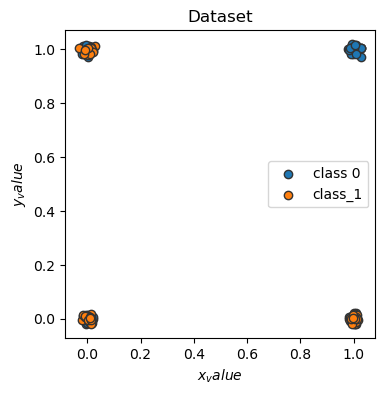

In [13]:
visualize(datasets.data,datasets.label)
plt.show()

In [14]:
class SpiralDataset(Dataset):
    def __init__(self, N = 100, C = 3, noise = 0.1):
        self.N = N
        self.C = C
        self.noise = noise
        self.generate_spiral()

    def generate_spiral(self):
        data_list = []
        label_list = []
        
        for class_number in range(self.C):
            r = torch.linspace(0, 1, self.N)
            theta = torch.linspace(class_number * 4, (class_number + 1) * 4, self.N)
            x = r * torch.sin(theta * 2.5) + self.noise * torch.randn(self.N)
            y = r * torch.cos(theta * 2.5) + self.noise * torch.randn(self.N)

            class_data = torch.stack([x, y], dim = 1)
            data_list.append(class_data)
            label_list.append(torch.full((self.N,), class_number, dtype=torch.long))

        self.data = torch.cat(data_list, dim = 0)
        self.label =  torch.cat(label_list, dim = 0)

    def __getitem__(self, idx):
          return self.data[idx], self.label[idx]


    def __len__(self):
          return self.N * self.C

      

In [15]:
classes = SpiralDataset(N = 100, C = 3, noise = 0.1)

print("classes", classes)
print("classes[0]", classes[0])

classes <__main__.SpiralDataset object at 0x00000144E41D78C0>
classes[0] (tensor([0.0183, 0.0331]), tensor(0))


In [16]:
def visualize(data, label):
    if isinstance(data, torch.Tensor):
        data = data.cpu().numpy()
    if isinstance(label, torch.Tensor):
        label = label.cpu().numpy()

    data_0 = data[label == 0]
    data_1 = data[label == 1]


    plt.figure(figsize=(4,4))
    plt.scatter(data_0[:, 0], data_0[:,1], edgecolor = "#333", label = "class_0")
    plt.scatter(data_1[:, 0], data_1[:, 1], edgecolor = "#333", label = "class_1")
    plt.title("Dataset")
    plt.xlabel("$X00X_values$")
    plt.ylabel("Y00Y_values$")

    plt.legend()


    

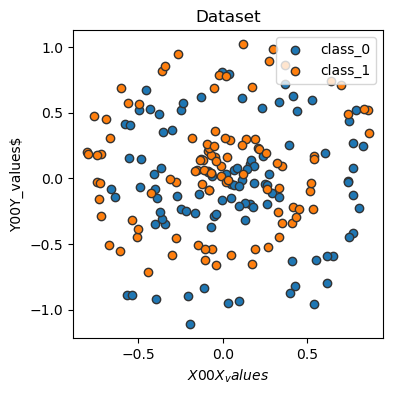

In [17]:
visualize(classes.data, classes.label)
plt.show()

In [18]:
class GaussianBlobs3D(Dataset):
    def __init__(self, N = 100, C = 3, std = 0.1):
        self.N = N
        self.C = C
        self.std = std
        self.generate_blobs()


    def generate_blobs(self):
        data_list = []
        label_list = []

        centers = torch.rand(self.C,3) * 5

        for Class_number in range(self.C):
            points = centers[Class_number]+self.std * torch.randn(self.N, 3)
            label = torch.full((self.N,),Class_number, dtype = torch.long)
            data_list.append(points)
            label_list.append(label)

        self.data = torch.cat(data_list, dim = 0)
        self.label = torch.cat(label_list, dim = 0)

    def __getitem__(self, idx):
        return self.data[idx], self.label[idx]

    def __len__(self):
        return self.N * self.C

In [19]:
close = GaussianBlobs3D(N = 100, C =3, std = 0.1)
close

In [20]:
print("close[0]", close[0])

close[0] (tensor([3.4680, 0.7207, 4.4015]), tensor(0))


In [21]:
def visualize(data, label):
    if isinstance(data, torch.Tensor):
       data = data.cpu().numpy()
    if isinstance(label, torch.Tensor):
       label = label.cpu().numpy()

    data_0 = data[label == 0]
    data_1 = data[label == 1]

    plt.figure(figsize=(6,6))
    plt.scatter(data_0[:,0], data_0[:, 1], edgecolor = "#333", label = "class_0")
    plt.scatter(data_1[:,0], data_1[:, 1], edgecolor = "#333", label = "class_1")
    plt.xlabel("$200$")
    plt.ylabel("$400$")

    plt.legend()

    

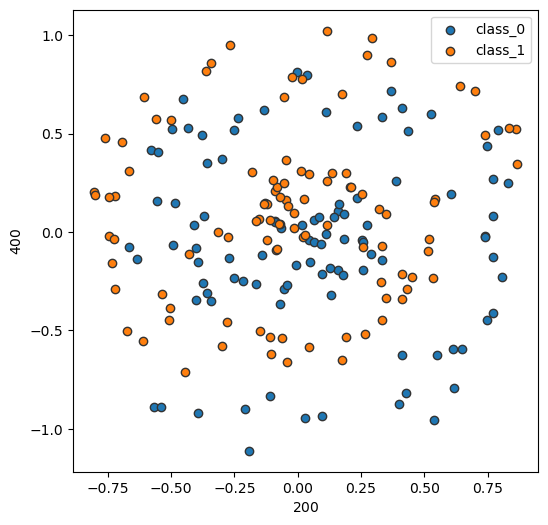

In [22]:
visualize(classes.data, classes.label)

In [23]:
dataloader = DataLoader(datasets, batch_size = 3, shuffle = True)
dataloader

In [24]:
dataload = DataLoader(classes, batch_size = 3, shuffle = True)
dataload

In [25]:
dataloads = DataLoader(close, batch_size = 3, shuffle =True)
dataloads

In [26]:
data_point, label_point = next(iter(dataloader))
print("data_point", data_point.shape)
print("label_point", label_point.shape)

data_point torch.Size([3, 3])
label_point torch.Size([3])


In [27]:
data_list, label_list = next(iter(dataload))
print("data_list", data_list.shape)
print("label_list", label_list.shape)

data_list torch.Size([3, 2])
label_list torch.Size([3])


In [28]:
data_list, label_list = next(iter(dataloads))
print("data_list", data_list)
print("label_list", label_list)

data_list tensor([[ 0.1758,  3.3845,  0.2546],
        [ 0.3136,  3.1493, -0.1113],
        [ 3.5581,  0.7668,  4.3967]])
label_list tensor([1, 1, 0])


In [29]:
loss = nn.BCEWithLogitsLoss()
loss

BCEWithLogitsLoss()

In [30]:
loss

BCEWithLogitsLoss()

In [31]:
loss = nn.BCEWithLogitsLoss()
loss

BCEWithLogitsLoss()

In [32]:
optimizer = torch.optim.SGD(model.parameters(), lr = 0.1)
optimizer

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.1
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)

In [33]:
train_dataset_1 = XORDataset(size = 2500)
train_dataset_1_loader = DataLoader(train_dataset_1, shuffle = True, batch_size = 100)
train_dataset_1_loader

In [34]:
train_dataset_2 = SpiralDataset(N = 200, C = 300)
train_dataset_2_loader = DataLoader(train_dataset_2, shuffle = True, batch_size = 100)
train_dataset_2_loader

In [35]:
train_dataset_3 = GaussianBlobs3D(N = 200, C = 300)
train_dataset_3_loader = DataLoader(train_dataset_3, shuffle = 3, batch_size = 30)
train_dataset_3_loader

In [36]:
model.to(device)

MyCategorical(
  (linear1): Linear(in_features=3, out_features=5, bias=True)
  (act_fn): Tanh()
  (linear2): Linear(in_features=5, out_features=1, bias=True)
)

In [37]:
from tqdm import tqdm

In [38]:
def training_dataset_1(model, optimizer, dataloader, loss, num_epochs = 100):
    model.train()

    for epoch in tqdm(range(num_epochs)):
        for data_input, data_labels in dataloader:

            data_input = data_input.to(device)
            data_labels = data_labels.to(device)


            preds = model(data_input)
            preds = preds.squeeze(dim=1)
        
            loss_value = loss(preds, data_labels.float())

            optimizer.zero_grad()

            loss_value.backward()

            optimizer.step()

        

In [39]:
training_dataset_1(model, optimizer, dataloader, loss)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.14it/s]


In [40]:
for x, y in dataloader:
    print("x shape:", x.shape)
    print("one sample:", x[0])
    break


x shape: torch.Size([3, 3])
one sample: tensor([ 0.0038, -0.0051,  1.0014])


In [41]:
model = MyCategorical(num_input = 2, num_hidden_size = 5, num_output = 1)
model

MyCategorical(
  (linear1): Linear(in_features=2, out_features=5, bias=True)
  (act_fn): Tanh()
  (linear2): Linear(in_features=5, out_features=1, bias=True)
)

In [42]:
def training_dataset_2(model, optimizer, dataload, loss, num_epochs = 200):
    model.train()

    for epoch in tqdm(range(num_epochs)):
        for data_input, data_label in dataload:
            data_input = data_input.to(device)
            data_label = data_label.to(device)

            preds = model(data_input)
            preds = preds.squeeze(dim = 1)

            loss_value = loss(preds, data_label.float())

            optimizer.zero_grad()

            loss_value.backward()

            optimizer.step()

In [43]:
training_dataset_2(model, optimizer, dataload, loss)

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:14<00:00, 14.03it/s]


In [44]:
model = model.state_dict()
print("model", model)

model OrderedDict({'linear1.weight': tensor([[ 0.4511,  0.0491],
        [ 0.4645, -0.4292],
        [-0.0316,  0.0154],
        [-0.6462, -0.0846],
        [ 0.6923,  0.2185]]), 'linear1.bias': tensor([ 0.3008, -0.1782,  0.4628, -0.3667, -0.4620]), 'linear2.weight': tensor([[ 0.3000,  0.1994, -0.3687, -0.2212,  0.4380]]), 'linear2.bias': tensor([-0.0885])})


In [45]:
x, y = next(iter(dataload))
print(x.shape)


torch.Size([3, 2])


In [46]:
x, y = next(iter(dataloads))
print(x.shape)

torch.Size([3, 3])


In [47]:
model = MyCategorical(num_input = 3, num_hidden_size = 5, num_output = 1)
model

MyCategorical(
  (linear1): Linear(in_features=3, out_features=5, bias=True)
  (act_fn): Tanh()
  (linear2): Linear(in_features=5, out_features=1, bias=True)
)

In [48]:
def training_dataset_3(model, optimizer, dataloads, loss, num_epochs = 200):
    model.train()

    for epoch in tqdm(range(num_epochs)):
        for data_point, data_label in dataloads:
            data_point = data_point.to(device)
            data_label = data_label.to(device)

            preds = model(data_point)
            preds = preds.squeeze(dim = 1)

            loss_values = loss(preds, data_label.float())

            optimizer.zero_grad()

            loss_values.backward()

            optimizer.step()

In [49]:
training_dataset_3(model, optimizer, dataloads, loss)

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:16<00:00, 12.36it/s]


In [50]:
## saving model - state_dict()
models = model.state_dict()
print("model", models)

model OrderedDict({'linear1.weight': tensor([[ 0.1928, -0.5211, -0.1164],
        [-0.3685,  0.1354,  0.2120],
        [ 0.4157,  0.1970,  0.5029],
        [-0.0856,  0.3445, -0.2246],
        [ 0.5612, -0.4044, -0.1036]]), 'linear1.bias': tensor([-0.2660, -0.3336, -0.5149, -0.3245, -0.3941]), 'linear2.weight': tensor([[ 0.1640,  0.1673,  0.1231,  0.2145, -0.2331]]), 'linear2.bias': tensor([0.0099])})


In [51]:
torch.save(models, "dir") ## saving our models

In [52]:
models = torch.load("dir")   ## loading our new files saved to our directory
models

OrderedDict([('linear1.weight',
              tensor([[ 0.1928, -0.5211, -0.1164],
                      [-0.3685,  0.1354,  0.2120],
                      [ 0.4157,  0.1970,  0.5029],
                      [-0.0856,  0.3445, -0.2246],
                      [ 0.5612, -0.4044, -0.1036]])),
             ('linear1.bias',
              tensor([-0.2660, -0.3336, -0.5149, -0.3245, -0.3941])),
             ('linear2.weight',
              tensor([[ 0.1640,  0.1673,  0.1231,  0.2145, -0.2331]])),
             ('linear2.bias', tensor([0.0099]))])

In [53]:
## creating new models

new_models = MyCategorical(num_input = 3, num_hidden_size = 5, num_output = 1)
new_models

MyCategorical(
  (linear1): Linear(in_features=3, out_features=5, bias=True)
  (act_fn): Tanh()
  (linear2): Linear(in_features=5, out_features=1, bias=True)
)

In [54]:
new_models.load_state_dict(models)

<All keys matched successfully>

In [55]:
print("model.state_dict", model.state_dict())
print("new_model.state_dict", new_models.state_dict())

model.state_dict OrderedDict({'linear1.weight': tensor([[ 0.1928, -0.5211, -0.1164],
        [-0.3685,  0.1354,  0.2120],
        [ 0.4157,  0.1970,  0.5029],
        [-0.0856,  0.3445, -0.2246],
        [ 0.5612, -0.4044, -0.1036]]), 'linear1.bias': tensor([-0.2660, -0.3336, -0.5149, -0.3245, -0.3941]), 'linear2.weight': tensor([[ 0.1640,  0.1673,  0.1231,  0.2145, -0.2331]]), 'linear2.bias': tensor([0.0099])})
new_model.state_dict OrderedDict({'linear1.weight': tensor([[ 0.1928, -0.5211, -0.1164],
        [-0.3685,  0.1354,  0.2120],
        [ 0.4157,  0.1970,  0.5029],
        [-0.0856,  0.3445, -0.2246],
        [ 0.5612, -0.4044, -0.1036]]), 'linear1.bias': tensor([-0.2660, -0.3336, -0.5149, -0.3245, -0.3941]), 'linear2.weight': tensor([[ 0.1640,  0.1673,  0.1231,  0.2145, -0.2331]]), 'linear2.bias': tensor([0.0099])})


In [56]:
test_data_1=XORDataset(size = 500)
test_data_loader = DataLoader(test_data_1, shuffle = True, batch_size = 100)
test_data_loader

In [57]:
test_data_2 = SpiralDataset(N = 20, C = 30)
test_datas = DataLoader(test_data_2, shuffle = True, batch_size = 100)
test_datas

In [58]:
test_data_3 = GaussianBlobs3D(N = 200, C = 300)
test_data_3 = DataLoader(test_data_3, shuffle = 3, batch_size = 30)
test_data_3

In [59]:
def test_data(model, dataloader):
    model.eval()
    true_preds = 0
    num_preds = 0

    with torch.no_grad():
        for data_input, data_label in dataloader:
            data_input = data_input.to(device)
            data_label = data_label.to(device)


            preds = model(data_input)
            preds = preds.squeeze(dim = 1)

            preds = torch.sigmoid(preds)
            preds_labels = (preds >=0.5).long()

            true_preds += (preds_labels == data_label).sum()
            num_preds += data_label.shape[0]

        act = true_preds / num_preds
        print("true accuracy:", act)
            
        

In [60]:
test_data(model, test_data_loader)

true accuracy: tensor(0.4980)


In [61]:
from matplotlib.colors import to_rgba

In [62]:
datasets = XORDataset(size = 200)
print("datasets", datasets)
print("the length of the datasets", len(datasets))
print("the dataset 0 ", datasets[0])

datasets <__main__.XORDataset object at 0x00000144E4220FC0>
the length of the datasets 200
the dataset 0  (tensor([-0.0313,  1.0091,  0.0011]), tensor(1))


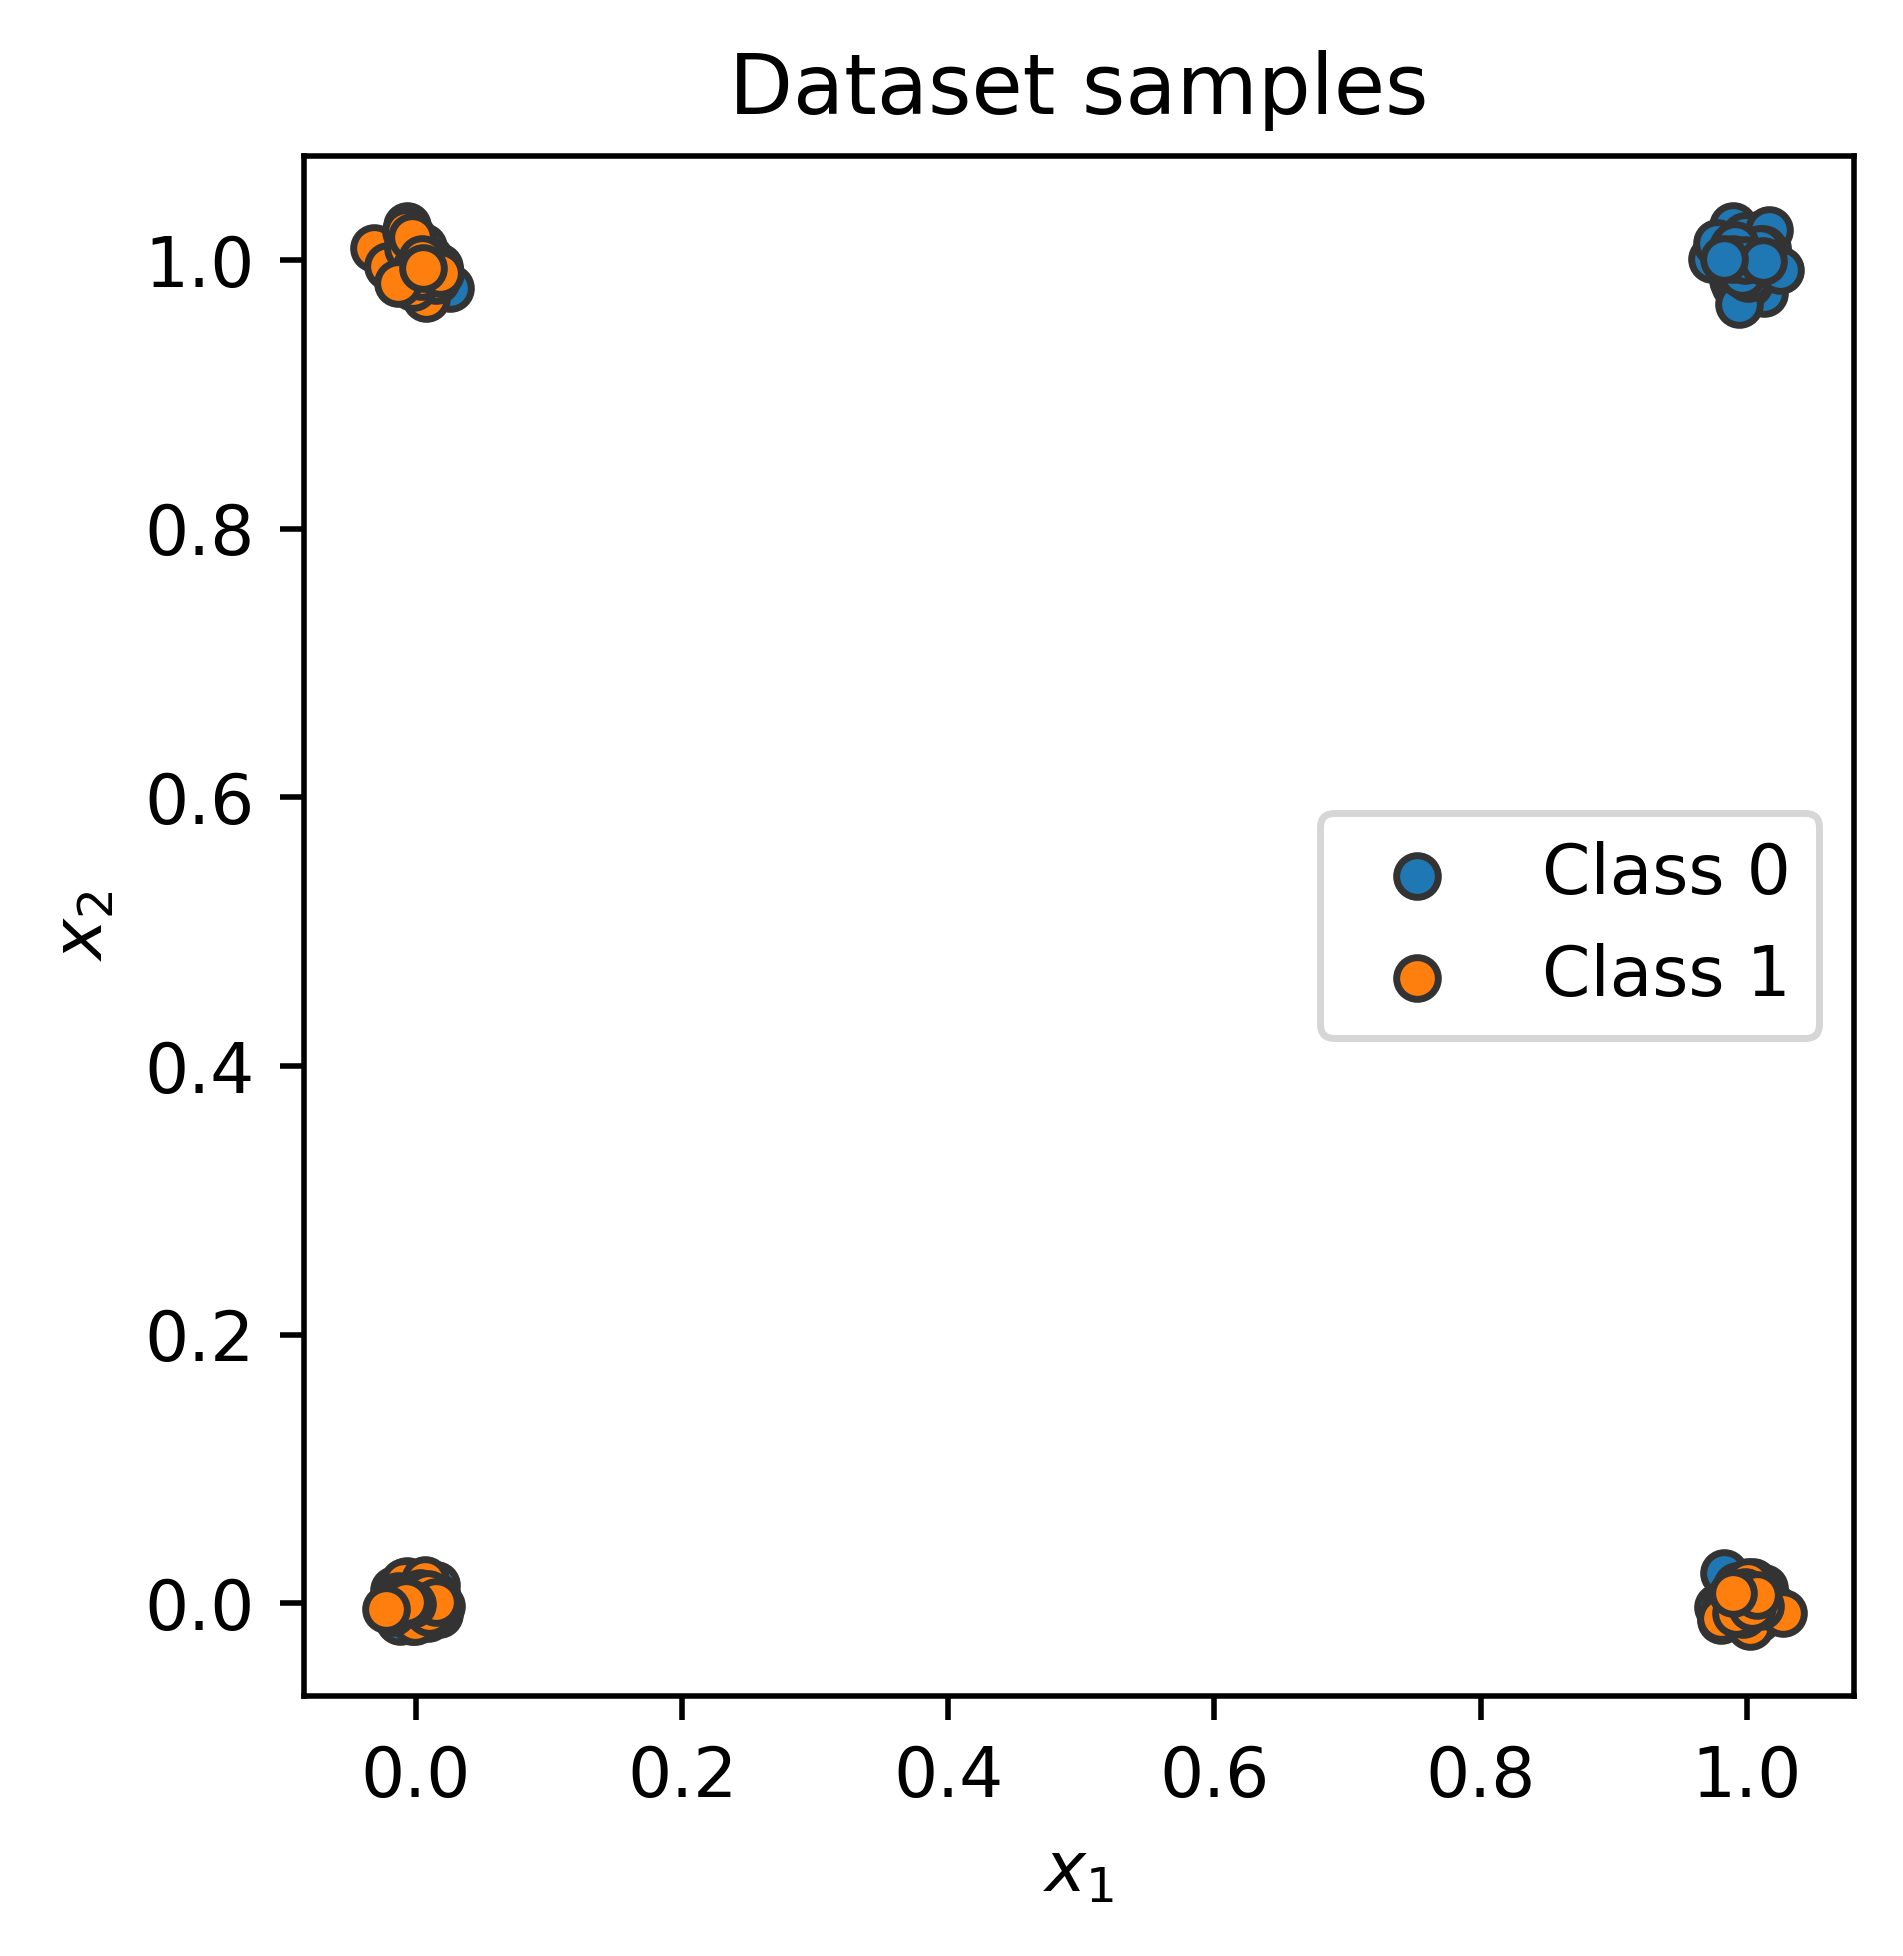

In [63]:
@torch.no_grad() # Decorator, same effect as "with torch.no_grad(): ..." over the whole function.
def visualize_classification(model, data, label):
    if isinstance(data, torch.Tensor):
        data = data.cpu().numpy()
    if isinstance(label, torch.Tensor):
        label = label.cpu().numpy()
    data_0 = data[label == 0]
    data_1 = data[label == 1]

    fig = plt.figure(figsize=(4,4), dpi=500)
    plt.scatter(data_0[:,0], data_0[:,1], edgecolor="#333", label="Class 0")
    plt.scatter(data_1[:,0], data_1[:,1], edgecolor="#333", label="Class 1")
    plt.title("Dataset samples")
    plt.ylabel(r"$x_2$")
    plt.xlabel(r"$x_1$")
    plt.legend()

_ = visualize_classification(model, datasets.data, datasets.label)
plt.show()

In [64]:
from torch.utils.tensorboard import SummaryWriter

C:\Users\ACE\anaconda3\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [65]:
%load_ext tensorboard

In [66]:
def training_log_tensorboard(model, optimizer, dataloader, loss, val_dataset, num_epochs = 30, logging_dir = "Experiment/logging_dir"):
    writer = SummaryWriter(logging_dir)
    model_plotted = False

    model.train()

    ## training_loops
    for epoch in tqdm(range(num_epochs)):
        epoch_loss = 0.0
        for data_input, data_label in (dataloader):
            data_input = data_input.to(device)
            data_label = data_label.to(device)


            if not model_plotted:
                writer.add_graph(model, data_input)
                model_plotted = True


            preds = model(data_input)
            preds = preds.squeeze(dim = 1)


            loss_value = loss(preds, data_label.float())

            optimizer.zero_grad()

            loss_value.backward()

            optimizer.step()
            
            epoch_loss += loss_value.item()
            
            epoch_loss /= len(dataloader)

            writer.add_scalar("training_loss",
                              epoch_loss,
                              global_step = epoch + 1)


        if (epoch + 1) %  10 == 0:
            fig = visualize_classification(model, val_dataset.data, val_dataset.label)
            writer.add_figure('predictions',
                              fig,
                              global_step = epoch + 1)

            plt.figure(fig)

    writer.close()
            
        
        

 30%|████████████████████████▉                                                          | 9/30 [00:00<00:01, 18.39it/s]


AttributeError: 'NoneType' object has no attribute 'canvas'

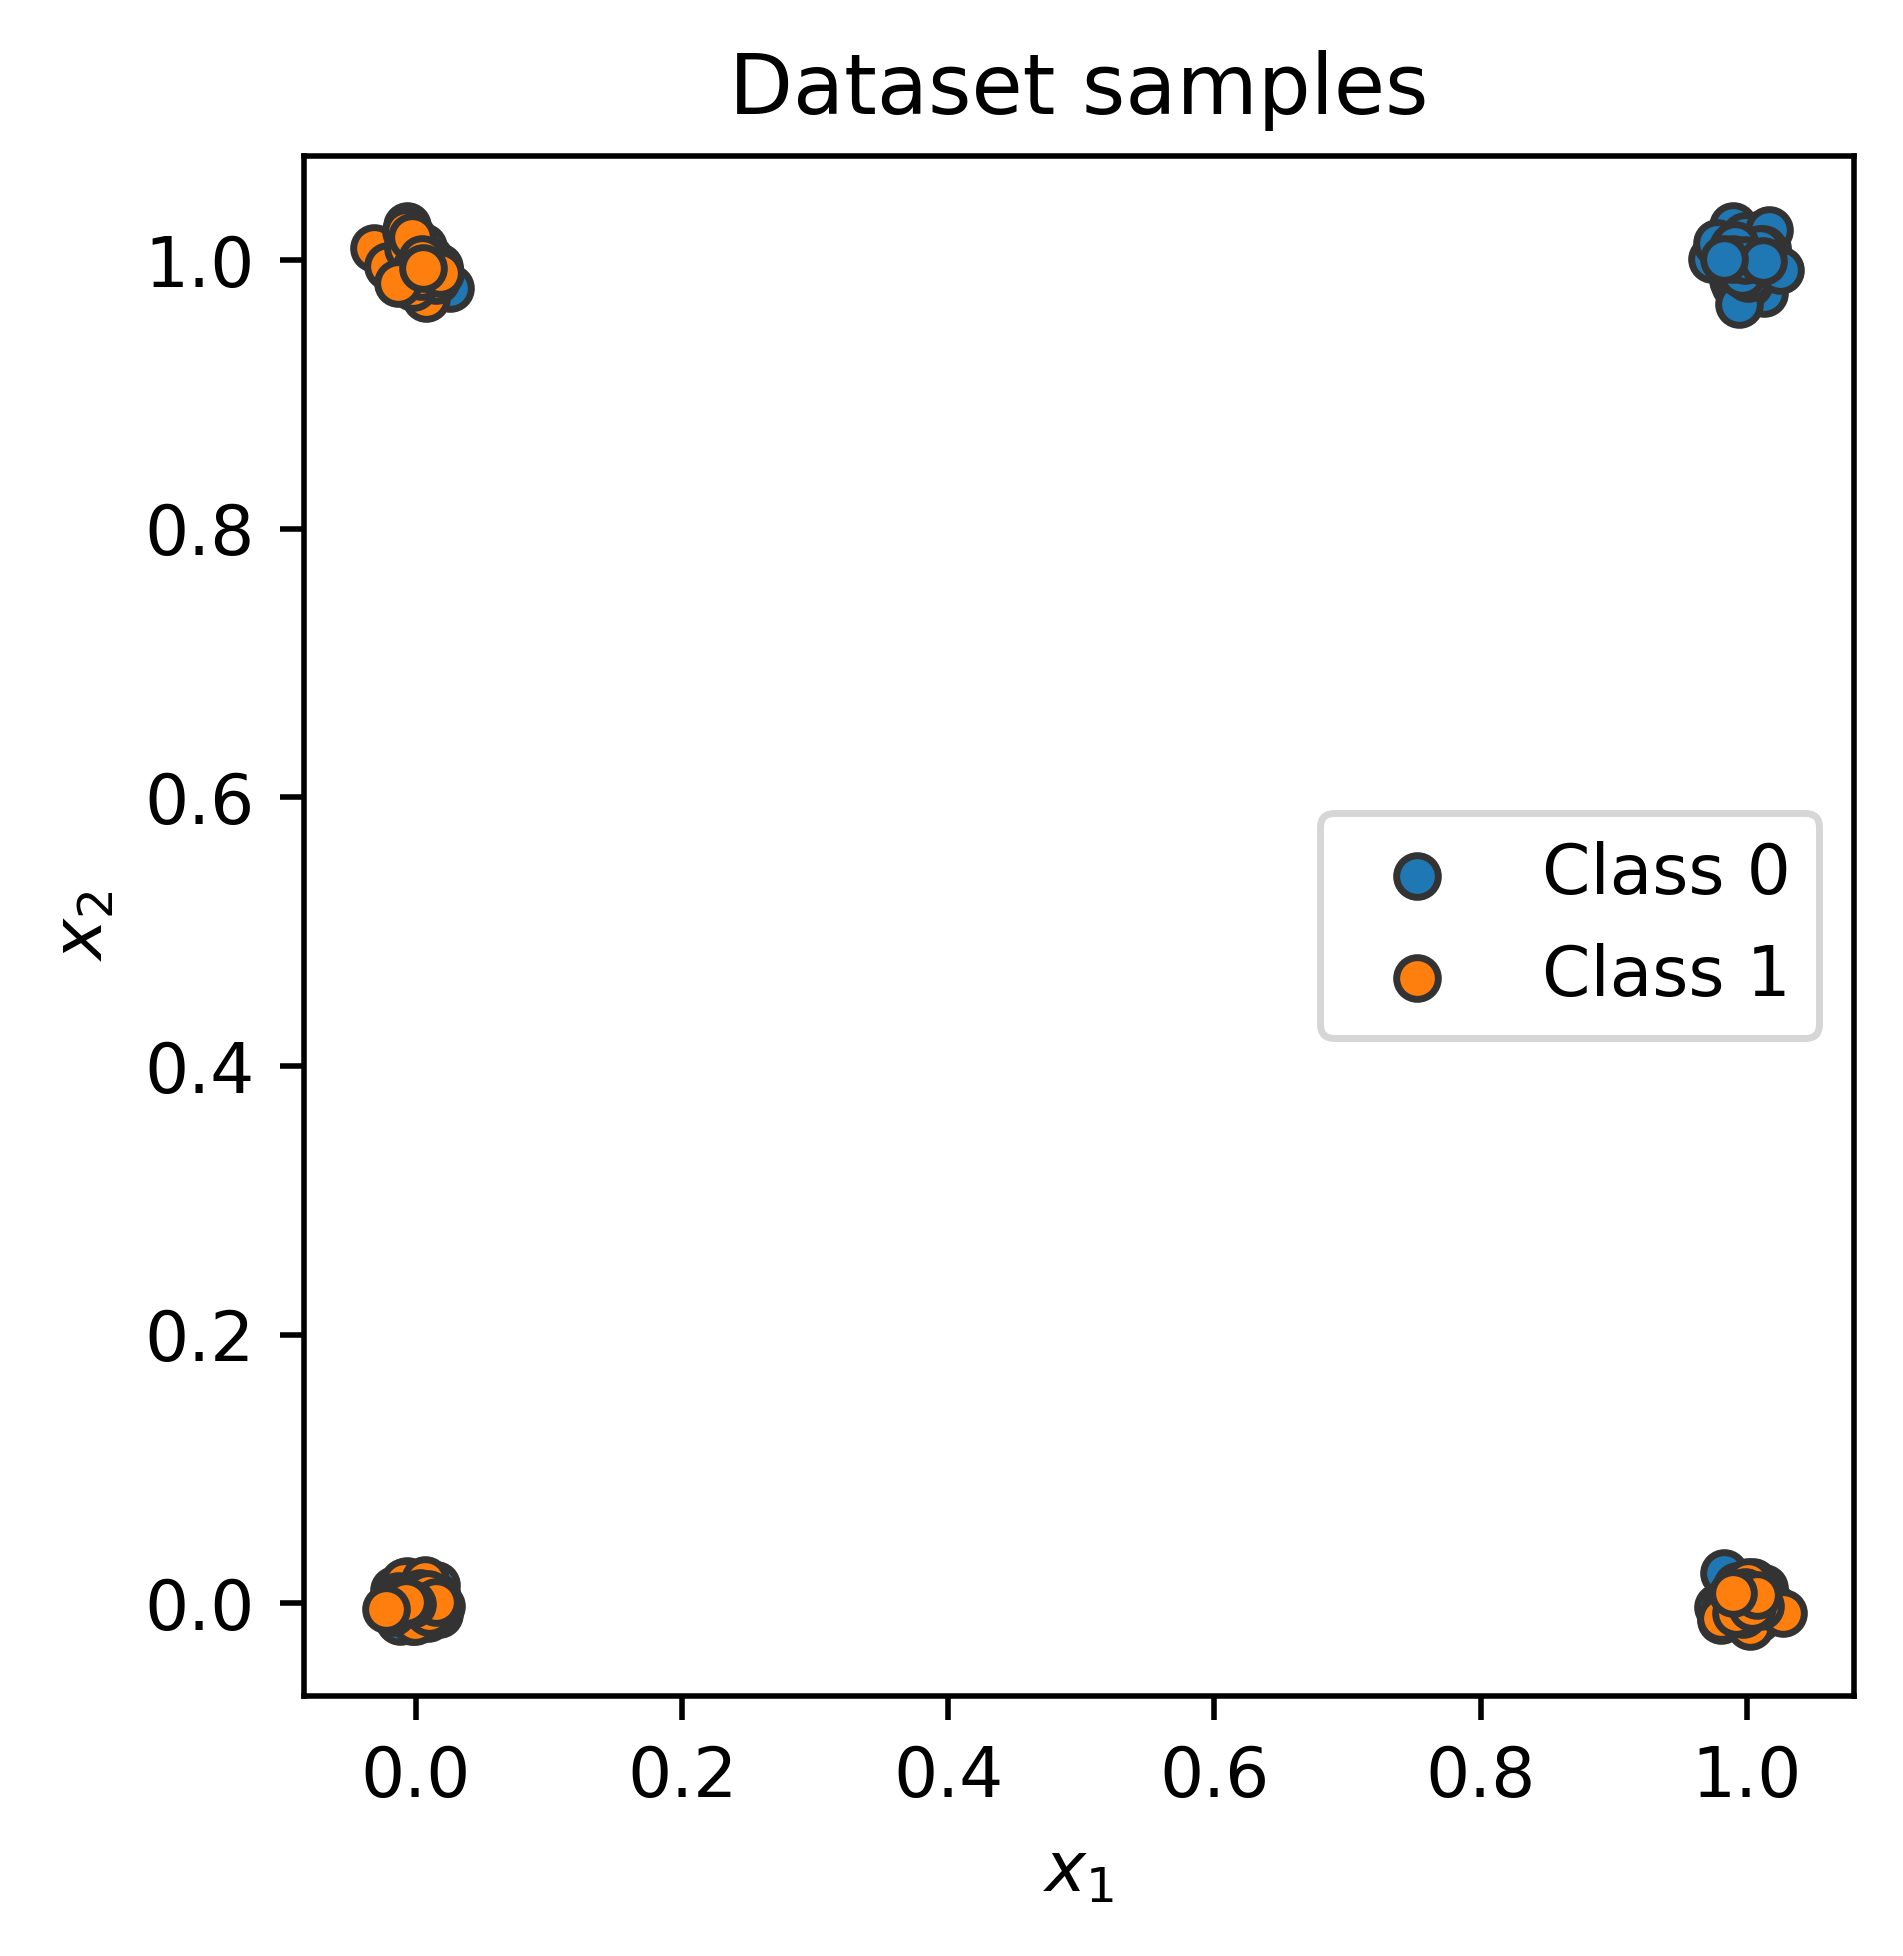

In [67]:
model = MyCategorical(num_input=3, num_hidden_size=4, num_output=1).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
training_log_tensorboard(model, optimizer, train_dataset_1_loader, loss, val_dataset=datasets)

In [68]:
def training_log_tensorboard(model, optimizer, dataloader, loss, val_dataset, num_epochs=30, logging_dir="Experiment/logging_dir"):
    writer = SummaryWriter(logging_dir)
    model_plotted = False
    model.train()

    for epoch in tqdm(range(num_epochs)):
        epoch_loss = 0.0

        for data_input, data_label in dataloader:
            data_input = data_input.to(device)
            data_label = data_label.to(device)

            # Log model graph once
            if not model_plotted:
                writer.add_graph(model, data_input)
                model_plotted = True

            preds = model(data_input)
            preds = preds.squeeze(dim=1)
            loss_value = loss(preds, data_label.float())

            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()

            epoch_loss += loss_value.item()

        # Average loss per epoch
        epoch_loss /= len(dataloader)
        writer.add_scalar("training_loss", epoch_loss, global_step=epoch + 1)

        # Optional visualization every 10 epochs
        if (epoch + 1) % 10 == 0:
            fig = visualize_classification(model, val_dataset.data, val_dataset.label)
            writer.add_figure('predictions', fig, global_step=epoch + 1)
            plt.close(fig)  # Free memory

    writer.close()


In [69]:
@torch.no_grad()
def visualize_classification(model, data, label):
    if isinstance(data, torch.Tensor):
        data = data.cpu().numpy()
    if isinstance(label, torch.Tensor):
        label = label.cpu().numpy()

    data_0 = data[label == 0]
    data_1 = data[label == 1]

    fig = plt.figure(figsize=(4, 4), dpi=100)  # Create a figure
    plt.scatter(data_0[:, 0], data_0[:, 1], edgecolor="#333", label="Class 0")
    plt.scatter(data_1[:, 0], data_1[:, 1], edgecolor="#333", label="Class 1")
    plt.title("Dataset samples")
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.legend()

    # Create meshgrid for model predictions
    x1 = torch.arange(-0.5, 1.5, step=0.01, device=device)
    x2 = torch.arange(-0.5, 1.5, step=0.01, device=device)
    xx1, xx2 = torch.meshgrid(x1, x2, indexing="ij")
    model_inputs = torch.stack([xx1, xx2], dim=-1)  # Shape: [N, N, 2]
    model_inputs_flat = model_inputs.reshape(-1, 2)  # Flatten for model

    preds = model(model_inputs_flat)
    preds = torch.sigmoid(preds).reshape(xx1.shape).cpu().numpy()

    # Plot the decision boundary
    plt.contourf(xx1.cpu(), xx2.cpu(), preds, alpha=0.3, levels=[0, 0.5, 1], colors=["C0", "C1"])
    
    return fig  # ✅ Return the figure, do NOT call plt.show()


 30%|████████████████████████▉                                                          | 9/30 [00:00<00:00, 21.88it/s]


RuntimeError: mat1 and mat2 shapes cannot be multiplied (40000x2 and 3x4)

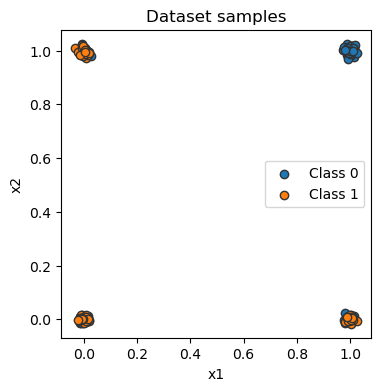

In [70]:
model = MyCategorical(num_input=3, num_hidden_size=4, num_output=1).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
training_log_tensorboard(model, optimizer, train_dataset_1_loader, loss, val_dataset=datasets)

In [72]:
%tensorboard --logdir runs/our_experiment

Reusing TensorBoard on port 6006 (pid 5016), started 0:04:52 ago. (Use '!kill 5016' to kill it.)